## 합성곱 신경망을 활용한 큐-함수

딥 큐-러닝은 큐 값의 정확도를 높이려고 합성곱 신경망을 도입했습니다.

이제 딥 큐-러닝(DQN)을 예제로 살펴보겠습니다.

이번에 진행할 예제에서는 OpenAI Gym의 CartPole-v1을 이용합니다. CartPole-v1의 에이전트는 카트에 부착된 막대기가 수직 상태를 유지할 수 있도록 카트를 왼쪽 또는 오른쪽으로 이동하는 작업을 반복합니다. 즉, 중심을 찾기 위해 지속적으로 이동하는 과정을 반복합니다.

![](../pytorch_wikidocs/Static/660.jpg)

에이전트가 환경의 현재 상태를 관찰하고 카트를 오른쪽 혹은 왼쪽으로 이동하면 환경은 새로운 상태로 전이되고 행동(왼쪽 혹은 오른쪽 이동)의 결과로 보상을 받게 됩니다. 보상은 +1이 주어집니다. 막대기가 중심에서 너무 멀리 떨어지거나 카트가 중심에서 멀어지면 게임은 종료됩니다. 즉, 게임이 오래 지속될수록 더 많은 보상을 받을 수 있습니다.

예제를 실행하기 위해 다음 패키지를 설치합니다.
pip install gym

`gym`은 손쉽게 강화 학습 환경을 구성할 수 있도록 도와주는 파이썬 패키지입니다. 

예제는 파이토치 튜토리얼에서 제공하는 코드를 조금 수정한 것입니다. 튜토리얼의 코드와 비교하면서 살펴보거나 직접 조금씩 변경하여 학습하면 빠르게 실력을 향상시킬 수 있습니다.
먼저 필요한 라이브러리를 호출합니다.

In [26]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple # 튜플에 담긴 요소들의 인덱스와 값으로 모두 접근 가능
from itertools import count # 무한 루프 사용을 위한 라이브러리
from PIL import Image # 이미지 처리를 위한 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

# cartpole 이라는 강화 학습 환경을 불러옵니다.
env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)




cuda


다음은 출력 결과에서 한글이 깨지는 현상을 방지하기 위한 코드를 작성합니다. 경로 변경 없이 그대로 사용해야 합니다.

In [27]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

DQN은 리플레이 메모리를 사용합니다. 리플레이 메모리에 에이전트가 관찰한 `상태 전이(state transition)`, `상태`, `행동` 등을 저장하여 나중에 재사용합니다.

In [28]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    

* `Transition = namedtuple('Transition',('state','action','next_state','reward'))` 

    `namedtuple`에는 상태 전이와 관련된 정보들을 포함합니다. 현재의 상태와 행동(state, action)은 다음 상태와 보상(next_state, reward)로 매핑됩니다. 즉, 현재의 상태에 대해 행동을 하게 되면 그것에 대한 보상이 주어지고 다음 상태를 보여 주기 때문에 현재 상태, 행동, 다음 상태, 보상에 대한 정보들을 관리합니다.

* `class ReplayMemory(object)`

    `리플레이 메모리(버퍼)` 에는 최근에 관찰된 전이(transition), 현재 상태, 행동, 다음 상태, 보상 정보들이 담기게 됩니다. 또한, `.sample()` 메서드는 리플레이 메모리에 저장된 데이터 중 랜덤하게 배치 크기(batch_size)만큼 반환합니다.

    Cartpole 에제는 통제된 상황(에이전트의 모든 행동이 예측 가능한 상황)을 가정합니다. 하지만 현실에서는 완벽하게 통제된 상황은 존재하지 않습니다. 따라서 DQN 신경망을 이용하여 Q(action - value) 함수와 유사하도록 네트워크를 생성합니다. 또한, 모델 학습의 목표는 누적보상이 최대가 되는 것입니다.

In [29]:
# DQN 모델 네트워크

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size -1) -1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1)) # 함수의 반환값은 다음 행동을 결정하기 위해 사용



* 선형 계층의 입력은 `합성곱층(conv2d)`의 출력과 입력 이미지의 크기에 따라 달라지므로 `convw * convh * 32` 와 같이 계산해야 합니다.

이제 환경에서 이미지를 추출하고 처리하는 함수를 정의합니다. 이때 다양한 이미지 변환을 쉽게 처리할 수 있도록 torchvision 패키지를 사용합니다.

먼저 pyglet 패키지를 설치합니다.

C:\Users\aqs45\AppData\Local\Temp\ipykernel_576\2076529346.py:7: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use BICUBIC or Resampling.BICUBIC instead.
  transforms.Resize(40, interpolation=Image.CUBIC),


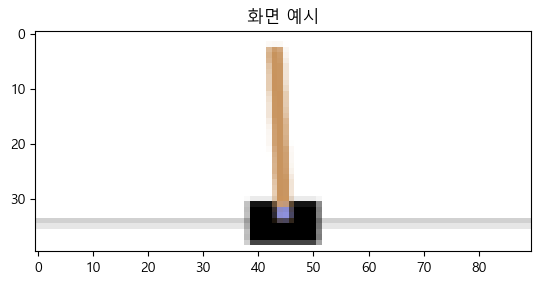

In [33]:
import pyglet
import torchvision
import numpy as np

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(40, interpolation=Image.CUBIC),
    transforms.ToTensor()
])

def get_cart_location(screen_width): #카트의 위치 정보 가져오기
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) # 카트의 중앙위치

def get_screen():
    screen = env.render().transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width=screen_width)

    if cart_location < view_width // 2: # 카트는 출력 화면의 아래쪽 중앙에 존재하므로 화면의 위쪽과 아래쪽을 제거
        slice_range = slice(view_width)
    
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    
    screen = screen[:, :, slice_range] # 카트가 화면의 중앙에 위치하도록 가장자리를 제거
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen) # 텐서로 변환
    return resize(screen).unsqueeze(0).to(device=device)

env.reset() # 환경을 초기화
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')  # permute 함수는 transpose 함수처럼 차원을 바꾸어서 표현할 때 사용
plt.title('화면 예시')
plt.show()

In [34]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device,  dtype=torch.long)


episode_durations = []


In [35]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool) 
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch 

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [39]:
num_episodes = 50

for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('종료')
env.render()
env.close()
plt.show()


종료


In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [11]:
torch.version.cuda

'11.6'

In [12]:
import torch
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))


Torch version:1.13.1+cu116
cuda version: 11.6
